The Hamiltonian in the charge basis is given by

$$
H = \sum_n \left[4E_c(n-n_g)^2 \ket n \bra n - E_j(\ket n \bra{n+1} + \ket{n+1} \bra n)\right]
$$

In [362]:
import numpy as np
import matplotlib.pyplot as plt
import math
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif' 

Firstly the eigenenergies of the qubit Hamiltonian


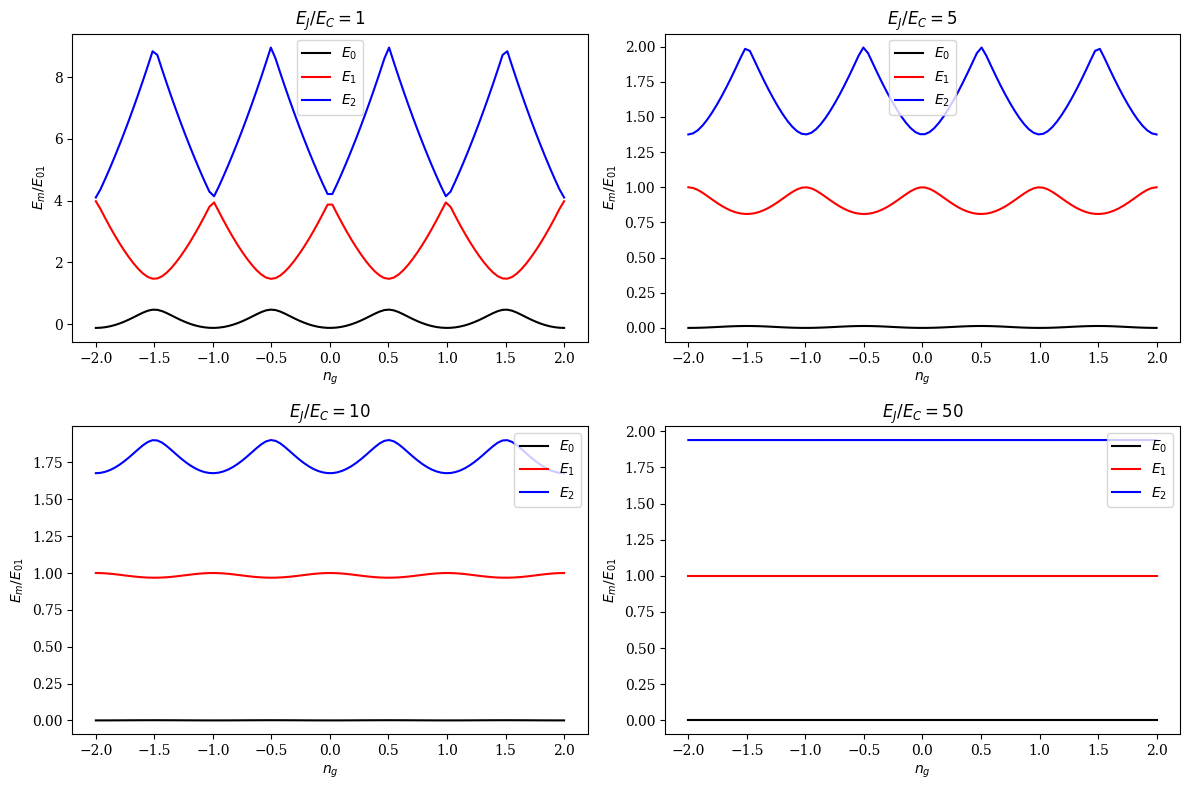

In [370]:
EjEc_values = np.array([1, 5, 10, 50])  # E_J / E_C values
E_C = 1  # Set E_C = 1 for simplicity (Charging energy)
n = np.arange(-10, 11)

n_g_values = np.linspace(-2, 2, 100) 
energy_levels = {EjEc: [] for EjEc in EjEc_values}
for EjEc in EjEc_values:
    E_J = EjEc * E_C 
    levels = []    
    for n_g in n_g_values:
        diag = 4 * E_C * (n - n_g)**2
        off_diag = -E_J / 2 * np.ones(len(n) - 1)
        # Construct the Hamiltonian matrix (charging + Josephson energy)
        H = np.diag(diag) + np.diag(off_diag, 1) + np.diag(off_diag, -1)
        eigenvalues, _ = np.linalg.eigh(H) # energies
        levels.append(eigenvalues[:3])
    energy_levels[EjEc] = np.array(levels)

fig, axs = plt.subplots(2, 2, figsize=(12, 8)) 
axs = axs.ravel()

for idx, EjEc in enumerate(EjEc_values):
    levels = energy_levels[EjEc]
    ax = axs[idx]
    # Compute E_{01} at n_g = 0 (first transition energy at n_g = 0)
    E_01_initial = levels[0, 1] - levels[0, 0]
    
    if EjEc == 1:
        ax.plot(n_g_values, levels[:, 0], label='$E_0$', c="black")
        ax.plot(n_g_values, levels[:, 1], label='$E_1$', c="red")
        ax.plot(n_g_values, levels[:, 2], label='$E_2$', c="blue")
    else:
        # Shift and plot E_0 (apply small positive shift to match the paper)
        ax.plot(n_g_values, (levels[:, 0] - levels[:, 0].min()) / E_01_initial, label='$E_0$', c="black")
        # Normalize and plot E_1 and E_2
        ax.plot(n_g_values, (levels[:, 1] - levels[:, 0]) / E_01_initial, label='$E_1$', c="red")
        ax.plot(n_g_values, (levels[:, 2] - levels[:, 0]) / E_01_initial, label='$E_2$', c="blue")
    
    ax.set_title(f'$E_J/E_C = {EjEc}$')
    ax.set_xlabel('$n_g$')
    ax.set_ylabel('$E_m / E_{01}$')
    ax.legend()

plt.tight_layout()
plt.show()


Reconstruction of figure. 4a) charge dispersion curves.

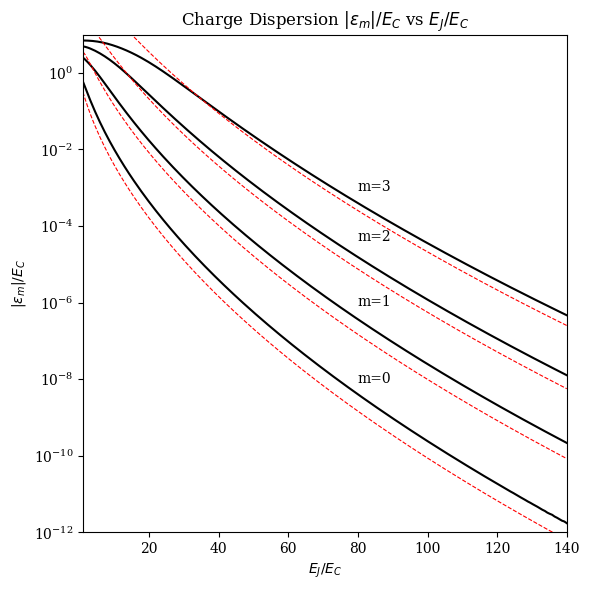

In [364]:
E_C = 0.35  # Charging energy in GHz
EjEc_values = np.linspace(1, 140, 200)  # E_J / E_C values
n = np.arange(-20, 21) 

def charge_dispersion(EjEc_values, E_C, m_values=[0, 1, 2, 3]):
    dispersion_values = {m: [] for m in m_values}
    for EjEc in EjEc_values:
        E_J = EjEc * E_C
        
        # Diagonal term at n_g = 1/2
        diag_1_2 = 4 * E_C * (n - 1/2)**2  
        off_diag = -E_J / 2 * np.ones(len(n) - 1)
        H_1_2 = np.diag(diag_1_2) + np.diag(off_diag, 1) + np.diag(off_diag, -1)
        eigenvalues_1_2, _ = np.linalg.eigh(H_1_2)  # Eigenvalues at n_g = 1/2
        
        # Diagonal term at n_g = 0
        diag_0 = 4 * E_C * (n - 0)**2
        H_0 = np.diag(diag_0) + np.diag(off_diag, 1) + np.diag(off_diag, -1)
        eigenvalues_0, _ = np.linalg.eigh(H_0)  # Eigenvalues at n_g = 0
        
        for m in m_values:
            epsilon_m = eigenvalues_1_2[m] - eigenvalues_0[m]  # Energy difference
            dispersion_values[m].append(abs(epsilon_m) / E_C)  # Normalize and store absolute value
    
    return dispersion_values

dispersion_values = charge_dispersion(EjEc_values, E_C)

# Asymptotic expansion (Eq. 2.5) for large E_J/E_C
def eps_m_asymptotic(m, EjEc_values, E_C):
    return E_C * (2**(4*m + 5) / math.factorial(m)) * (np.sqrt(2 / np.pi) * (EjEc_values / 2)**(m/2 + 3/4)) * np.exp(-np.sqrt(8 * EjEc_values))

plt.figure(figsize=(6, 6))

# Exact results (solid lines)
for m, epsilon_m in dispersion_values.items():
    plt.plot(EjEc_values, epsilon_m, label=f'm={m}', c='black')

# Asymptotic results (dashed red lines)
for m in range(4):
    plt.plot(EjEc_values, eps_m_asymptotic(m, EjEc_values, E_C), c='r', linestyle='--', lw=0.8)

plt.yscale('log')
plt.xlim(1, 140)
plt.ylim(1e-12, 10) 
plt.xlabel('$E_J / E_C$')
plt.ylabel('$|\\varepsilon_m| / E_C$')
plt.title('Charge Dispersion $|\\varepsilon_m| / E_C$ vs $E_J / E_C$')

plt.text(80, 8E-9, 'm=0')
plt.text(80, 8E-7, 'm=1')
plt.text(80, 4E-5, 'm=2')
plt.text(80, 8E-4, 'm=3')

plt.tight_layout()
plt.show()


Reconstruction of 5a) anharmonicity at degeneracy point.

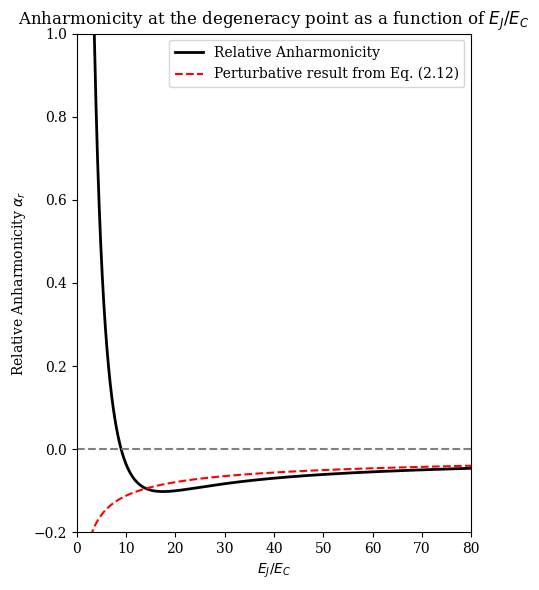

In [366]:
EjEc_values = np.linspace(1, 80, 1000)
E_C = 1
n = np.arange(-10, 11)
anharmonicity_rel = []
perturbation = lambda EJEC: -(8*EJEC)**(-1/2) # Perturbative solution 

for EjEc in EjEc_values:
    E_J = EjEc * E_C 
    n_g = 0.5  # Sweet spot
    diag = 4 * E_C * (n - n_g)**2
    off_diag = -E_J / 2 * np.ones(len(n) - 1)
    H = np.diag(diag) + np.diag(off_diag, 1) + np.diag(off_diag, -1)
    eigenvalues, _ = np.linalg.eigh(H)
    E_0, E_1, E_2 = eigenvalues[:3]
    
    # Relative anharmonicity
    E_01 = E_1 - E_0  # First transition
    E_12 = E_2 - E_1  # Second transition
    alpha_abs = E_12 - E_01
    alpha_rel = alpha_abs / E_01
    anharmonicity_rel.append(alpha_rel)


anharmonicity_rel = np.array(anharmonicity_rel)
plt.figure(figsize=(5, 6))

plt.plot(EjEc_values, anharmonicity_rel, label='Relative Anharmonicity', c="black", lw=2)
plt.plot(EjEc_values, perturbation(EjEc_values),linestyle='--', c='r', label ='Perturbative result from Eq. (2.12)')
plt.xlabel('$E_J / E_C$')
plt.ylabel(r'Relative Anharmonicity $\alpha_r$')
plt.title('Anharmonicity at the degeneracy point as a function of $E_J / E_C$')
plt.axhline(y=0, linestyle='--', c='gray')
plt.legend()
plt.ylim([-0.2, 1])
plt.xlim(0,80)
plt.tight_layout()
plt.show()